# Занятие 13. Кластерный анализ

In [1]:
import os
os.chdir("C:/Users/HP/Documents/analysis/Marketing/data/")

## Аббакумов В.Л.

Иерархическая кластеризация
=============

Полезные ссылки:
* https://docs.scipy.org/doc/scipy-0.14.0/reference/cluster.hierarchy.html
* https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* http://scikit-learn.org/stable/modules/clustering.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
import os

Пример 1. Beverage
--------

In [4]:
import os
os.chdir("C:/Users/HP/Documents/analysis/Marketing/data/")

In [5]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')

In [6]:
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


Применим алгоритм иерархической кластеризации и построим дендрограмму. Все необходимые вычисления проводятся в функции linkage. Кроме самих данных, ей нужно передать на вход два аргумента: метод вычисления расстояний между кластерами (```ward```, ```single```, ```complete```, ```average```) и метрику (```euclidean``` (default), ```cityblock``` aka Manhattan, ```hamming```, ```cosine```). См. [документацию]( https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(df, 'ward', 'euclidean')

Объект ```link``` представляет собой матрицу ```(n-1) x 4```, где ```n``` -- число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```link[i, 0]``` и ```link[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```link[i, 2]``` означает расстояние между слитыми кластерами, а ```link[i, 3]``` -- размер нового кластера.

In [7]:
link[:5]

array([[ 5., 10.,  0.,  2.],
       [ 1.,  2.,  0.,  2.],
       [ 4., 35.,  0.,  3.],
       [ 3., 22.,  0.,  2.],
       [20., 36.,  0.,  4.]])

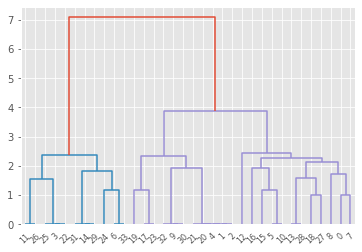

In [13]:
# Функция для построения дендрограммы
dn = dendrogram(link)

Алгоритм подкрасил в дендрограмме два кластера, но здесь, скорее, кластера всё-таки три. Теперь хочется посмотреть, какими характеристиками различаются наши кластеры.

Сначала добавим к данным колонку ```cluster```, в которую запишем номер кластера, в которую попал объект. Это сделаем с помощью функции ```fcluster```. В качестве первого аргумента передаём объект ```linkage```, полученный выше. Третьим аргументом ```criterion``` передаём критерий для разбиения на кластеры (```distance``` для остановки разбиения по расстоянию между кластерами и ```maxclust``` для разбиения по заданному числу кластеров). Вторым же аргументом является либо пороговое значение для расстояния между кластерами, либо количество кластеров, в зависимости от аргумента ```criterion```.

In [14]:
# Останавливаем объединение, если расстояние между кластерами превышает 3
df['cluster'] = fcluster(link, 3, criterion='distance')

Теперь вычислим средние значения всех характеристик, сгруппировав данные по номеру кластера. Используем стандартную конструкцию: вызов метода ```groupby``` с последующим применением группирующей функции.

In [10]:
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.00,1.000000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,1.00,0.272727,0.090909,0.000000,1.000000,0.000000,0.000000,0.272727
3,0.75,0.250000,0.083333,0.083333,0.416667,0.916667,0.083333,0.500000


Также интересно узнать, сколько наблюдений попало в каждый кластер. Для этого также применяем вызов ```groupy``` с последующим применением метода ```size```.

In [11]:
df.groupby('cluster').size()

cluster
1    11
2    11
3    12
dtype: int64

**Каменистая осыпь**

А можно было выбрать число кластеров не на глаз по дендрограмме, а автоматически, тем более если данных много? Можно. Построим график, носящий название "каменистая осыпь". Напомним, в матрице ```link``` во второй колонке хранятся расстояния между парами слитых кластеров. По построению, строки матрицы упорядочены по этой колонке.

In [12]:
dist = link[:, 2]
dist

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.15470054, 1.15470054, 1.15470054,
       1.54919334, 1.58113883, 1.73205081, 1.82574186, 1.91485422,
       1.93649167, 2.12132034, 2.27636073, 2.33711814, 2.37920282,
       2.446395  , 3.87646865, 7.09212963])

Таким образом, можно построить график зависимости расстояний между кластерами от шага слияния (обратного), и посмотреть, начиная с какого момента это расстояние перестанет значительно меняться.

Text(22, 2.6, '4 clusters')

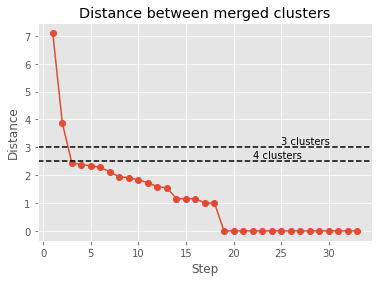

In [13]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(3, c='k', linestyle='dashed')
plt.axhline(2.52, c='k', linestyle='dashed')
plt.text(25, 3.1, '3 clusters')
plt.text(22, 2.6, '4 clusters')

Из картинки видно, что если мы остановимся объединять кластеры при расстоянии равном примерно 2.5, мы получим 4 кластера, а при равном 3 -- 3 кластера.

Однако, строго говоря, этот способ всё ещё немасштабируем для больших данных. Но его можно просто поправить, включая в график не все подряд слияния, а только несколько последних. И если уж мы совсем хотим автомаизировать процесс, то факт сильного изменения расстояний между кластерами можно фиксировать с помощью производной: там где график выходит на горизонталь, производная станет почти нулём.

Пример 2. Кластеризация претендентов
----------------------

In [14]:
df = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
df.head()

,NR,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
NAME,,,,,,,,,,,
Volker,1,10,10,9,10,10,10,9,10,10,9
Sigrid,2,10,10,4,10,5,5,4,5,4,3
Elmar,3,5,4,10,5,10,4,10,5,3,10
Peter,4,10,10,9,10,10,10,9,10,10,9
Otto,5,4,3,5,4,3,10,4,10,10,5


In [15]:
# В колонке NR находится номер объекта, его нужно исключить из данных для кластеризации
del df['NR']

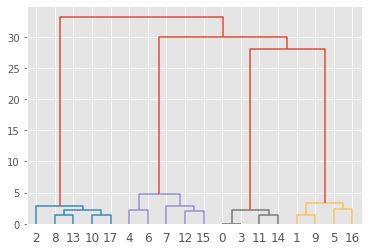

In [16]:
link = linkage(df, 'ward', 'euclidean')
dn = dendrogram(link)

In [17]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')

In [18]:
df.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50
4,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25


Пример 3. Потребление протеинов в Европе
------------------

In [19]:
df = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
df.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


Стандартизация данных
--------------------
В этом примере данные, которые мы собираемся кластеризовать, хотя и находятся в одних и тех же единицах измерения, но местами они различаются почти на два порядка, так что будет не лишним их стандартизировать перед анализом. 

В модуле preprocessing библиотеки sklearn реализованы несколько классов стандартизации данных:
* StandardScaler -- приведение к нулевому среднему и единичной дисперсии.
* MinMaxScaler -- приведение данных к отрезку [0, 1].
* MaxAbsScaler -- приведение к [-1, 1] (рекомендуется для разреженных данных).

Замечание. У этих методов есть чуть более лёгкие методы-аналоги ```scale```, ```minmax_scale``` и ```maxabs_scale```, которые делают практически то же самое, но для supervized задач машинного обучения, которые встретяся позже, удобнее использовать именно изначально указанные классы.

Процесс стандартизации выглядит так:

In [20]:
from sklearn import preprocessing

# Выбираем один из вариантов нормализации

norm = preprocessing.StandardScaler()
# norm = preprocessing.MaxAbsScaler()
# norm = preprocessing.MinMaxScaler()

# вычисляем параметры нормализации (они будут сохранены внутри объекта norm)
norm.fit(df)
# преобразовываем данные с параметрами
X = norm.transform(df)
# Полученный на предыдущем шаге объект X -- это матрица класса numpy.ndarray.
# Глазами на неё смотреть неудобно, лучше преобразовать её в объект класса pandas.DataFrame.
X = pd.DataFrame(X, index=df.index, columns=df.columns)

In [21]:
X.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,0.082941,-1.794750,-2.224584,-1.179570,-1.225033,0.934804,-2.295965,1.247968,-1.378251
Austria,-0.282974,1.686446,1.245621,0.400468,-0.655111,-0.395051,-0.422218,-0.910790,0.092789
Belgium,1.119699,0.387905,1.062979,0.055732,0.064791,-0.525246,0.889405,-0.499598,-0.076947
Bulgaria,-0.618396,-0.523837,-1.220051,-1.265754,-0.925074,2.273959,-1.983674,0.322786,0.036210
Czechoslovakia,-0.039031,0.968104,-0.124197,-0.662467,-0.685107,0.190830,0.452198,-1.013588,-0.076947


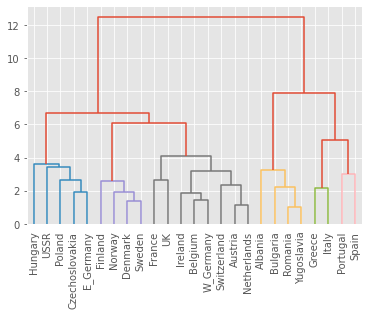

In [22]:
link = linkage(X, 'ward', 'euclidean')
dn = dendrogram(link,
                # массив с названиями объектов для подписи по оси X
                labels=X.index.tolist(),
                # опция для более красивого отображения слишком ветввистой дендрограммы
                truncate_mode='lastp',
                # повернуть подписи вертикально
                color_threshold=5,
                leaf_rotation=90.)

In [23]:
df['cluster'] = fcluster(link, 5, criterion='distance')

In [24]:
df.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
1,7.9200,10.0400,2.8400,13.8400,2.740,35.740,5.56,2.5400,4.260
2,9.8500,7.0500,3.1500,26.6750,8.225,22.675,4.55,1.1750,2.125
3,13.2125,10.6375,3.9875,21.1625,3.375,24.700,4.65,2.0625,4.175
4,7.1250,4.6750,1.2000,9.4500,0.750,51.125,1.95,5.0500,2.975
5,9.6000,4.0500,2.8500,15.6500,4.650,39.250,2.15,6.0500,6.600
6,6.6500,3.5500,2.1000,6.7500,10.600,28.100,5.80,5.3000,7.550


Кластеризация методом k-means (k-средних)
=============

Полезные ссылки:
* http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* http://scikit-learn.org/stable/modules/clustering.html

In [25]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

Пример 1. Beverage
--------

In [26]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


В scikit-learn процедура настройки и использования моделей часто проходит по одной и той же схеме:
1. Инициализация модели, задание её параметров,
2. Подгонка модели (метод fit и/или fit_transform),
3. Предсказание для новых наблюдений (метод predict).

Для кластеризации методом k-means необходимо задать k наперёд. Попробуем k = 2. 

In [27]:
from sklearn.cluster import KMeans
# инициализация модели
model = KMeans(n_clusters=2, random_state=42)
# random_state - зерно датчика случайных чисел. 
# При каждом новом вызове с одинаковыми random_state модель будет давать
# одинаковые результаты.

In [28]:
# подгонка модели по данным из df
model.fit(df)

KMeans(n_clusters=2, random_state=42)

In [29]:
# Результат кластеризации на данных df
model.labels_

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [30]:
# координаты центров кластеров
model.cluster_centers_

array([[ 9.52380952e-01,  2.38095238e-01,  4.76190476e-02,
        -8.32667268e-17,  7.61904762e-01,  4.28571429e-01,
         4.76190476e-02,  3.80952381e-01],
       [ 1.11022302e-16,  9.23076923e-01,  5.38461538e-01,
         5.38461538e-01, -5.55111512e-17,  1.53846154e-01,
         7.69230769e-01,  7.69230769e-02]])

In [31]:
# предсказание для новых наблюдений. Метод predict.
new_items = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
]
model.predict(new_items)

array([1, 0])

Модель выше разбивала на два кластера. 
Как определить число кластеров?
Применим модель для разного числа кластеров, чтобы построить график каменистой осыпи. Метод ```inertia_``` вернёт сумму расстояний от каждой точки данных до центра ближайшего к ней кластера. Таким образом, кластеризацию можно считать условно хорошей, когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


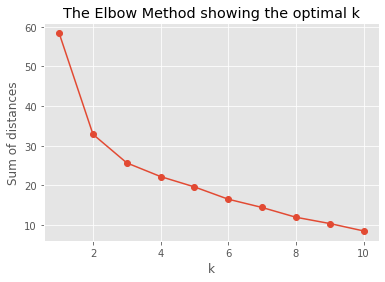

In [32]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Допустим, мы решили, что три кластера -- это оптимальный выбор. Теперь хочется посмотреть на список наблюдений, составляющий данные кластеры, и посмотреть, чем они отличаются друг от друга. Для этого применим метод ```labels_```, а затем посчитаем средние значения факторов для каждого кластера.

In [33]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
0,0.727273,0.272727,0.090909,0.090909,0.454545,1.0,0.090909,0.454545
1,0.000000,1.000000,0.545455,0.545455,0.000000,0.0,0.909091,0.000000
2,1.000000,0.250000,0.083333,0.000000,0.916667,0.0,0.000000,0.333333


In [34]:
df.groupby('cluster').size()

cluster
0    11
1    11
2    12
dtype: int64

Пример 2. Кластеризация претендентов
-------

In [35]:
df = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
df.head()

,NR,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
NAME,,,,,,,,,,,
Volker,1,10,10,9,10,10,10,9,10,10,9
Sigrid,2,10,10,4,10,5,5,4,5,4,3
Elmar,3,5,4,10,5,10,4,10,5,3,10
Peter,4,10,10,9,10,10,10,9,10,10,9
Otto,5,4,3,5,4,3,10,4,10,10,5


In [36]:
# В колонке NR находится номер объекта, его нужно исключить из данных для кластеризации
del df['NR']

In [37]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
cluster,,,,,,,,,,
0,4.8,4.4,4.00,4.0,4.20,10.0,4.40,10.00,10.00,5.00
1,4.2,4.8,10.00,4.4,10.00,4.4,10.00,4.00,3.80,10.00
2,10.0,10.0,4.25,10.0,4.75,4.5,3.75,4.25,4.25,4.25
3,10.0,10.0,9.00,10.0,10.00,9.5,9.25,9.75,10.00,9.50


Пример 3. Потребление протеинов в Европе
---------------------

In [38]:
df = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
df.head()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Country,,,,,,,,,
Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


In [39]:
# Стандартизируем данные
from sklearn import preprocessing
norm = preprocessing.StandardScaler()
norm.fit(df)
X = norm.transform(df)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


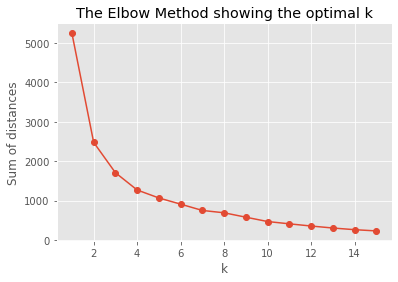

In [40]:
K = range(1, 16)
models = [KMeans(n_clusters=k).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
model = KMeans(n_clusters=6)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster,,,,,,,,,
0,8.475000,11.800000,3.375000,15.700000,3.125000,30.750000,5.25,1.300000,4.625000
1,8.780000,5.300000,2.240000,13.300000,2.560000,40.900000,3.06,5.280000,4.400000
2,6.650000,3.550000,2.100000,6.750000,10.600000,28.100000,5.80,5.300000,7.550000
3,6.133333,5.766667,1.433333,9.633333,0.933333,54.066667,2.40,4.900000,3.400000
4,9.850000,7.050000,3.150000,26.675000,8.225000,22.675000,4.55,1.175000,2.125000
5,13.828571,10.157143,3.942857,21.342857,3.557143,24.228571,4.80,2.171429,4.157143


In [42]:
df['cluster'].sort_values()

Country
Austria           0
Poland            0
Czechoslovakia    0
E_Germany         0
Albania           1
USSR              1
Hungary           1
Greece            1
Italy             1
Portugal          2
Spain             2
Bulgaria          3
Romania           3
Yugoslavia        3
Finland           4
Denmark           4
Norway            4
Sweden            4
Ireland           5
W_Germany         5
Netherlands       5
Switzerland       5
UK                5
Belgium           5
France            5
Name: cluster, dtype: int32